In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import numpy as np
import pandas as pd

In [3]:
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from tqdm import tqdm_notebook

In [5]:
from nas_environment import Environment

In [6]:
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.metrics.pairwise
from scipy.spatial import distance

In [8]:
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval

# Set-up the environment

In [9]:
precomputed_logs_path = 'train_logs_single_run/'

In [10]:
env = Environment(precomputed_logs_path)

In [11]:
len(env._logs)

14322

In [12]:
search_set = env.get_precomputed_recepies()

In [13]:
alg_resutls = {}

In [14]:
rounds = 5
iters_per_round = 100

# Random seach

In [15]:
for train_epochs in [10, 50]:
    all_test_losses = []
    all_wall_times = []

    N = int(iters_per_round*50/train_epochs)
    
    for seed in tqdm_notebook(range(rounds)):
        np.random.seed(seed)
        env.reset()
        selected_inds = []
        test_losses = []
        wall_times = []
        for i in range(N):
            cur_ind = np.random.choice(np.setdiff1d(np.arange(len(search_set)), np.array(selected_inds)), 
                                       1, replace=False)[0]
            env.simulated_train(search_set[cur_ind], train_epochs)
            selected_inds.append(cur_ind)
            test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
            wall_times.append(env.get_total_time())
        all_test_losses.append(test_losses)
        all_wall_times.append(wall_times)
    alg_resutls[f'random_search_{train_epochs}_epochs'] = {'all_test_losses':all_test_losses, 'all_wall_times':all_wall_times}

# Hyperbands

In [16]:
all_test_losses = []
all_wall_times = []
N = iters_per_round
for seed in tqdm_notebook(range(rounds)):
    env.reset()
    np.random.seed(seed)

    # HYPERBAND
    
    #inputs
    R = 50 # the maximum amount of resource that can be allocated to a single configuration (number of epochs)
    eta = 3 # an input that controls the proportion of configurations discarded in each round of SuccessiveHalving

    # initialization
    s_max = int(np.floor(np.log(R)/np.log(eta)))
    # B = (s_max + 1)*R
    B = N*R/3.5 # to approximately match budgets in random search

    test_losses = []
    wall_times = []
    
    log_cnt = 0
    for s in range(s_max, -1, -1):
        n = int(np.ceil(float(B)/R * float(eta)**s/(s + 1)))
        r = R*float(eta)**(-s)
        #print(s, n, r)
        # Successive Halving inner loop
        # init sample of n architectures
        T = np.random.choice(len(search_set), n, replace=False)
        #print(T)
        for i in range(s + 1):
            n_i = int(np.floor(n*float(eta)**(-i)))
            r_i = int(np.floor(r*eta**i))
            L = []
            for t in T:
                env.simulated_train(search_set[t], r_i)
                if env.get_model_status(search_set[t]) == 'OK':
                    L.append(env.get_model_stats(search_set[t], r_i - 1)['val_loss'])
                else:
                    L.append(np.inf) # if model fails accidently within r_i epichs, it is discated further
                log_cnt += 1
                if log_cnt % 25 == 0:
                    test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
                    wall_times.append(env.get_total_time())
            test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
            wall_times.append(env.get_total_time())

            L = np.array(L)
            halved_inds = np.argsort(L)[:int(np.floor(n_i/float(eta)))]
            halved_inds = halved_inds[L[halved_inds] < np.inf] # discard accidently failed models
            T = T[halved_inds]
            #print(T)
    all_test_losses.append(test_losses)
    all_wall_times.append(wall_times)
alg_resutls['hyperband'] = {'all_test_losses':all_test_losses, 'all_wall_times':all_wall_times}

# BayesOpt

In [17]:
df_recepie_vectors = pd.read_csv('data/doc2vec_features.csv').set_index('recepie_id')
df_recepie_vectors_lowdim = pd.read_csv('data/doc2vec_features_lowdim.csv').set_index('recepie_id')

In [18]:
search_set_recepie_ids = np.array(env.get_recepie_ids())

In [19]:
X_highdim = df_recepie_vectors.loc[search_set_recepie_ids].values
X_lowdim = df_recepie_vectors_lowdim.loc[search_set_recepie_ids].values

In [22]:
for X, alias in zip([X_highdim, X_lowdim], ['50D', '10D']):
#     if alias == '50D':
#         continue
    all_test_losses = []
    all_wall_times = []
    epochs_train = 50
    N_init = 20 # check randomly a few architectures at first
    beta = 2.0
    N = int(1.3*iters_per_round)
    train_batch = 10
    for seed in tqdm_notebook(range(rounds)):
    #for seed in tqdm_notebook(range(5)):
        np.random.seed(seed)
        env.reset()
        selected_inds = []
        test_losses = []
        wall_times = []
        X_train = []
        y_train = []
        # check a few random architectures at first
        for i in range(N_init):
            cur_ind = np.random.choice(np.setdiff1d(np.arange(len(search_set)), np.array(selected_inds)), 
                                       1, replace=False)[0]
            env.simulated_train(search_set[cur_ind], epochs_train)
            selected_inds.append(cur_ind)
            if env.get_model_status(search_set[cur_ind]) == 'OK':
                X_train.append(X[cur_ind])
                y_train.append(env.get_model_stats(search_set[cur_ind], epochs_train - 1)['val_loss'])
            test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
            wall_times.append(env.get_total_time())


        regr = BaggingRegressor(XGBRegressor(n_estimators=100, max_depth=15), 
                                n_estimators=14, max_samples=0.5, n_jobs=14)

        # train estimator and score new candidates according to the lower-confidence-bound acquisition function
        for i in range(N_init, N):
            if i % train_batch == 0:
                regr.fit(np.array(X_train), np.array(y_train))
                y_pred_mean = regr.predict(X)
                y_pred_std = np.std([e.predict(X) for e in regr.estimators_], axis=0)
                scores = y_pred_mean - beta * y_pred_std

            scores[np.array(selected_inds)] = np.inf

            cur_ind = np.argmin(scores)

            env.simulated_train(search_set[cur_ind], epochs_train)
            if env.get_model_status(search_set[cur_ind]) == 'OK':
                X_train.append(X[cur_ind])
                y_train.append(env.get_model_stats(search_set[cur_ind], epochs_train - 1)['val_loss'])
            selected_inds.append(cur_ind)
            test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
            wall_times.append(env.get_total_time())
        all_test_losses.append(test_losses)
        all_wall_times.append(wall_times)


    alg_resutls[f'bayes_opt_{alias}'] = {'all_test_losses':all_test_losses, 'all_wall_times':all_wall_times}

IndexError: list index out of range

# Regularized evolution

In [23]:
def mutate_embedded(e, std=1, axes_bounds=None):
    e_new = e + np.random.randn(len(e)) * std
    if axes_bounds is not None:
        e_new = np.clip(e_new, axes_bounds[0], axes_bounds[1])
    return e_new

In [24]:
def find_closest(E, e):
    #dists = np.linalg.norm(E - e.reshape(1, -1), axis=1)
    dists = distance.cdist([e], E, "cosine")[0]
    return np.argmin(dists)

In [25]:
all_test_losses = []
all_wall_times = []

train_epochs = 50
P = 20
C = int(1.3*iters_per_round)
S = 10

axes_bounds = (np.min(X, axis=0), np.max(X, axis=0))

for seed in tqdm_notebook(range(rounds)):
    np.random.seed(seed)
    env.reset()
    test_losses = []
    wall_times = []
    
    # init first P architectures
    population = []
    history = []
    for i in np.random.choice(np.arange(len(search_set)), P, replace=False):
        env.simulated_train(search_set[i], train_epochs)
        population.append(i)
        history.append(i)
        test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
        wall_times.append(env.get_total_time())
    
    attempt = 0
    valid_round = True
    while len(history) < C:
        sample = np.random.choice(population, S, replace=False)
        sample_scores = [env.get_model_stats(search_set[i], epochs_train - 1)['val_loss'] 
                         for i in sample if env.get_model_status(search_set[i]) == 'OK']
        if len(sample_scores) == 0: 
            # this is unlikely to happen, but just to make sure that the code will work anyway
            attempt += 1
            if attempt > 5:
                valid_round = False
                break
            else:
                continue
        else:
            attempt = 0
        parent = sample[np.argmin(sample_scores)]
        
        for std in [0.5, 1.0, 2.0, 4.0, 8.0]:
            e_new = mutate_embedded(X[parent], std, axes_bounds)
            child = find_closest(X, e_new)
            if child != parent:
                # stop when we find a child that differs from the parent
                break
        
        env.simulated_train(search_set[child], train_epochs)
        history.append(child)
        population = population[1:] + [child]
        test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
        wall_times.append(env.get_total_time())
    
    if valid_round:
        all_test_losses.append(test_losses)
        all_wall_times.append(wall_times)
    #break
    
alg_resutls['regularized_evolution'] = {'all_test_losses':all_test_losses, 'all_wall_times':all_wall_times}

# TPE

In [26]:
def objective_vec(vec):
    
    # The most similar vector in X:
    distances = distance.cdist([vec], X, "cosine")[0]
    #distances = np.linalg.norm(X - vec.reshape(1, -1), axis=1)
    recepie_id = np.argmin(distances)
    recepie = search_set[recepie_id]


    env.simulated_train(recepie, epochs_train)
    test_losses.append(env.get_test_loss_of_the_best_validated_architecture())
    wall_times.append(env.get_total_time())


    if env.get_model_status(recepie) == 'OK':
        result = env.get_model_stats(recepie, epochs_train - 1)['val_loss']
    else:
        result = 10
    return result

In [27]:
def objective_dict(vec_as_dict):
    
    vec = np.zeros(50)
    for k, v in vec_as_dict.items():
        vec[int(k)] = v
    
    return objective_vec(vec)

In [28]:
X = X_highdim

In [29]:
components_space = {}
for i in range(X.shape[-1]):
    min_val = X[:, i].min()
    max_val = X[:, i].max()
    components_space[i] = hp.uniform(f'component_{i}', min_val, max_val)
search_space = components_space

In [30]:
N = int(1.3*iters_per_round)

In [31]:
for epochs_train in [50]:
    all_test_losses = []
    all_wall_times = []

    for seed in tqdm_notebook(range(rounds)):
        np.random.seed(seed)
        os.environ['HYPEROPT_FMIN_SEED'] = str(seed)
        env.reset()
        test_losses, wall_times = [], []
        
        # minimize the objective over the space
        best = fmin(objective_dict, search_space, algo=tpe.suggest, max_evals=N,
                    verbose=False, show_progressbar=True, max_queue_len=20)
        all_test_losses.append(test_losses)
        all_wall_times.append(wall_times)

    alg_resutls[f'TPE_{epochs_train}_epochs'] = {'all_test_losses':all_test_losses, 'all_wall_times':all_wall_times}

# SMAC

In [32]:
from smac.facade.func_facade import fmin_smac
from smac.initial_design.latin_hypercube_design import LHDesign
import logging
from ConfigSpace.hyperparameters import UniformFloatHyperparameter

# Import ConfigSpace and different types of parameters
from smac.configspace import ConfigurationSpace
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.facade.smac_bo_facade import SMAC4BO
from smac.initial_design.latin_hypercube_design import LHDesign
from smac.optimizer.acquisition import LCB, EI, PI
from smac.runhistory.runhistory2epm import RunHistory2EPM4InvScaledCost
# Import SMAC-utilities
from smac.scenario.scenario import Scenario

ModuleNotFoundError: No module named 'smac'

In [ ]:
from smac.facade.smac_ac_facade import SMAC4AC
from smac.scenario.scenario import Scenario
from smac.tae.execute_ta_run import ExecuteTARun
from smac.tae.execute_func import ExecuteTAFuncDict
from smac.configspace import ConfigurationSpace
from smac.stats.stats import Stats
from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.initial_design.latin_hypercube_design import LHDesign
from ConfigSpace.hyperparameters import UniformFloatHyperparameter
import json
import pathlib

In [ ]:
class SMACUtils(object):
    def __init__(self, env, X=X, search_set=search_set,
                 epochs_train=epochs_train):

        self.env = env
        self.X = X
        self.search_set = search_set
        self.epochs_train = epochs_train
        self.stat = {}
#         self.stat_file = stat_file
        
#         with open(self.stat_file, "w") as f:
#             json.dump({}, f)
    
    def objective_function(self, config):
        vec = self._config_to_vec(config)
        
        distances = distance.cdist([vec], self.X, "cosine")[0]
        recepie_id = np.argmin(distances)
        recepie = self.search_set[recepie_id]
        
        self.env.simulated_train(recepie, self.epochs_train)
        
        test_loss = self.env.get_test_loss_of_the_best_validated_architecture()
        wall_time = self.env.get_total_time()
        self._collect_eval_stat(test_loss, wall_time)
        
        if self.env.get_model_status(recepie) == 'OK':
            r = self.env.get_model_stats(recepie, self.epochs_train - 1)['val_loss']
        else:
            r = 1000
        
        return r, {"test_loss": test_loss, "wall_time": wall_time}

        
    def _config_to_vec(self, config):
        vec_as_dict = config.get_dictionary()
        vec = np.zeros(self.X.shape[-1])
        for k, v in vec_as_dict.items():
            vec[int(k)] = v
        return vec
    
    def _collect_eval_stat(self, test_loss, wall_time):
        stat = self.stat
        
        if 'test_losses' not in stat:
            stat['test_losses'] = []
        stat['test_losses'].append(test_loss)
        
        if 'wall_times' not in stat:
            stat['wall_times'] = []
        stat['wall_times'].append(wall_time)
        
        if 'eval_step' not in stat:
            stat['eval_step'] = 0
        stat['eval_step'] += 1
        


In [ ]:
for X in [X_lowdim]:
    axes_bounds = (np.min(X, axis=0), np.max(X, axis=0))
    bounds = list(zip(axes_bounds[0], axes_bounds[1]))

    cs = ConfigurationSpace()
    cs.add_hyperparameters([
        UniformFloatHyperparameter(str(i), X[:, i].min(), X[:, i].max(), default_value=0)
        for i in range(X.shape[-1])
    ]);

    for initial_design in [LHDesign]: #[RandomConfigurations, LHDesign]:
        all_test_losses = []
        all_wall_times = []

        for seed in range(rounds):
            print(f"START WITH INITIAL DESIGN: {initial_design.__name__} SEED: {seed}")
            scenario = Scenario({"run_obj": "quality",
                             "runcount-limit": int(1.2*iters_per_round),
                             "wallclock-limit": 3000,
                             "cs": cs,
                             "deterministic": "true",
                             "initial_incumbent": "RANDOM",
                             "output_dir": "./tmp",
                             "seed": seed,
                             "limit_resources": "false"})

            env.reset()
            b = SMACUtils(env, X=X)

            def objective_function(config, **kwargs):
                y, stat = b.objective_function(config)
                return float(y)

            stats = Stats(scenario=scenario)
            smac = SMAC4AC(scenario=scenario,
                           tae_runner=objective_function,
                           initial_design=initial_design)
            smac.optimize()

            stat = b.stat
            all_test_losses.append(stat['test_losses'])
            all_wall_times.append(stat['wall_times'])

        alg_resutls[f'SMAC[{initial_design.__name__}_{X.shape[-1]}D]'] = {'all_test_losses':all_test_losses, 'all_wall_times':all_wall_times}

# Plot resuls

In [33]:
legend_algs = {
    'random_search_50_epochs': 'RS 50E',
    'random_search_10_epochs': 'RS 10E',
    'hyperband':'HB',
    'bayes_opt_50D':'BO 50D',
    'bayes_opt_10D':'BO 10D',
    'regularized_evolution':'RE',
    'TPE_50_epochs':'TPE',
    'SMAC[LHDesign_10D]':'SMAC'
}

In [34]:
y_opt = env.get_best_possible_test_loss()

/userhome/34/ecysit/NAS/nas-bench-nlp-release/nas_environment.py:34: RuntimeWarning: All-NaN axis encountered
  cur_loss = np.nanmin(log['test_losses'])


KeyError: 'bayes_opt_10D'

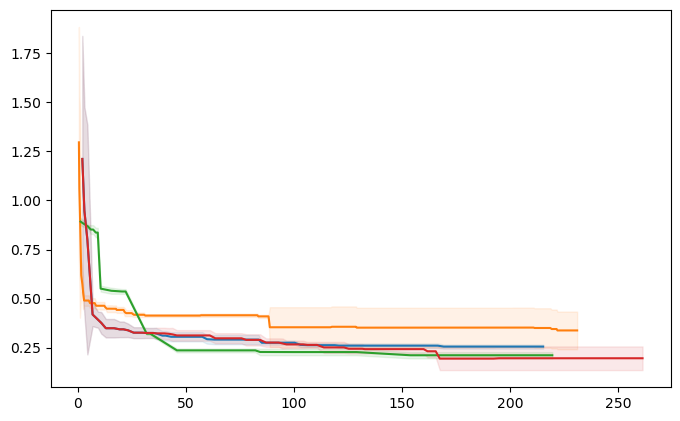

In [35]:
plt.figure(figsize=(8, 5), dpi=100)


for i, alg_name in enumerate(['random_search_50_epochs', 'random_search_10_epochs', 'hyperband', 
                              'bayes_opt_50D', 'bayes_opt_10D', 'regularized_evolution', 'TPE_50_epochs',
                             'SMAC[LHDesign_10D]']):
    all_test_losses = alg_resutls[alg_name]['all_test_losses']
    all_wall_times = alg_resutls[alg_name]['all_wall_times']

    all_xs = np.array(all_test_losses)
    all_ts = np.array(all_wall_times)/3600.

    s = 1.96/np.sqrt(all_xs.shape[0])

    all_ts_mean = all_ts.mean(axis=0)

    all_ts_max = all_ts_mean + s*all_ts.std(axis=0)
    all_ts_min = all_ts_mean - s*all_ts.std(axis=0)

    all_xs_mean = np.nanmean(all_xs, axis=0)

    all_xs_max = all_xs_mean + s*np.nanstd(all_xs, axis=0)
    all_xs_min = all_xs_mean - s*np.nanstd(all_xs, axis=0)


    plt.plot(all_ts_mean, all_xs_mean - y_opt, lw=1.5, color=f'C{i}', label=legend_algs[alg_name])

    plt.fill_between(all_ts_mean, all_xs_min - y_opt, all_xs_max - y_opt, alpha=0.1, edgecolor=f'C{i}')

plt.legend()
plt.xlabel('Total train time [h]', fontsize=14)
plt.ylabel('Regret', fontsize=14)
plt.ylim([0.1, 1.0])
plt.xscale('log')
plt.yscale('log')
plt.xlim([5, 1500])
plt.xticks([10, 20, 50, 100, 200, 500, 1000]);
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.savefig('data/figures/benchmarks_log_y_scale.png', dpi=300, bbox_inches='tight')

KeyError: 'bayes_opt_10D'

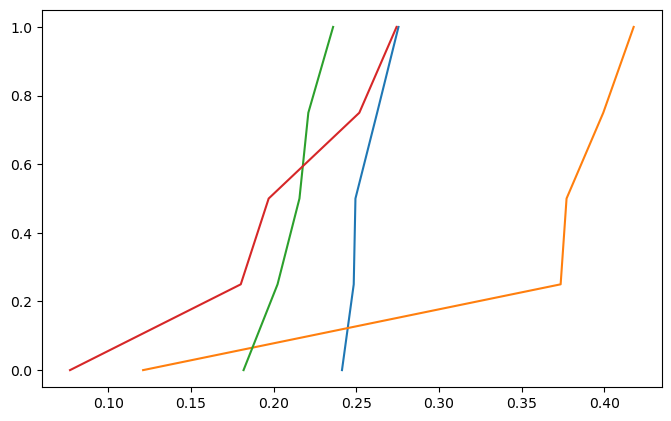

In [36]:
from matplotlib import ticker

plt.figure(figsize=(8, 5), dpi=100)

for i, alg_name in enumerate(['random_search_50_epochs', 'random_search_10_epochs', 'hyperband', 
                              'bayes_opt_50D', 'bayes_opt_10D', 'regularized_evolution', 'TPE_50_epochs',
                             'SMAC[LHDesign_10D]']):
    all_test_losses = alg_resutls[alg_name]['all_test_losses']
    all_wall_times = alg_resutls[alg_name]['all_wall_times']

    all_xs = np.array(all_test_losses)
    all_ts = np.array(all_wall_times)/3600.

    s = 1.96/np.sqrt(all_xs.shape[0])

    all_ts_mean = all_ts.mean(axis=0)

    all_ts_max = all_ts_mean + s*all_ts.std(axis=0)
    all_ts_min = all_ts_mean - s*all_ts.std(axis=0)

    all_xs_mean = np.nanmean(all_xs, axis=0)

    all_xs_max = all_xs_mean + s*np.nanstd(all_xs, axis=0)
    all_xs_min = all_xs_mean - s*np.nanstd(all_xs, axis=0)

    plt.plot(np.sort(all_xs[:, -1]) - y_opt, np.linspace(0, 1, len(all_xs)), color=f'C{i}', label=legend_algs[alg_name])
plt.legend()


plt.xlabel('Final test regret', fontsize=14)
plt.ylabel('CDF', fontsize=14)
plt.savefig('data/figures/benchmarks_CDF_regret.png', dpi=300, bbox_inches='tight')